In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from google.cloud import bigquery
import datetime
import copy

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

### Data Retrieval

In [3]:
REFRESH=False

In [4]:
if REFRESH:
    
    sql = '''
        DECLARE latest_date DATE;
        SET latest_date = (
            SELECT MAX(offer_start_date) 
            FROM `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales_solus` fcs
            WHERE campaign_code IN (
                SELECT DISTINCT campaign_code || '-' || campaign_type
                FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
            )
        );

        CREATE OR REPLACE TABLE `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_CAT_FORECASTING_EXEC_DEV` AS

        WITH dates_campaign AS (
            SELECT * 
            FROM (
                SELECT DISTINCT fw_start_date + 1 AS fw_start_date
                FROM `wx-bq-poc.loyalty.dim_date`
                WHERE fw_start_date >= '2021-04-19'
                    AND fw_start_date <= latest_date
            )
                CROSS JOIN (
                    SELECT DISTINCT 
                        Campaign_Seg_Grp_Id
                    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
                    WHERE Campaign_Seg_Grp_Id != 'None'
                )
            GROUP BY 1, 2
        ),
        
        audience AS (
            SELECT 
                campaign_start_date,
                Campaign_Seg_Grp_Id,
                COUNT(DISTINCT crn) AS audience
            FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER`
            GROUP BY 1,2
        ),

        promo AS (
            SELECT 
                ma.Campaign_Seg_Grp_Id,
                fcs.campaign_start_date,
                fcs.offer_start_date,
                fcs.campaign_week_nbr,
                COUNT(DISTINCT fcs.redeem_flag) AS redeemers,
                SUM(fcs.attributed_inc_sales) AS inc_sales,
                SUM(fcs.reward_val) AS cost
            FROM
                `wx-bq-poc.loyalty_bi_analytics.fact_campaign_sales_solus` fcs
                JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
                    ON fcs.crn = ma.crn
                    AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
                    AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
            WHERE offer_start_date >= '2021-04-19'
                AND offer_start_date <= latest_date
                AND Campaign_Seg_Grp_Id != 'None'
            GROUP BY 1,2,3,4
        ), 

        post AS (
            SELECT  
                ma.Campaign_Seg_Grp_Id,
                fcs.campaign_start_date,
                fcs.fw_start_date + 1,
                DATE_DIFF(fcs.fw_start_date + 1, fcs.campaign_start_date, DAY) / 7 + 1 AS campaign_week_nbr,
                0 AS redeemers,
                SUM(fcs.inc_sales) AS inc_sales,
                0 AS cost
            FROM 
                `wx-bq-poc.loyalty_bi_analytics.cp_att_crn_halo_post_all` fcs
                JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
                    ON fcs.crn = ma.crn
                    AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
                    AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
            WHERE fw_start_date >= '2021-04-19'
                AND fw_start_date <= latest_date
                AND Campaign_Seg_Grp_Id != 'None'
            GROUP BY 1,2,3,4
        ),
        
        _promo_post AS (
            SELECT * FROM promo 
            UNION ALL
            SELECT * FROM post
        ),
        
        promo_post AS (
            SELECT
                pp.*, a.audience
            FROM _promo_post pp
                JOIN audience a 
                    ON pp.Campaign_Seg_Grp_Id = a.Campaign_Seg_Grp_Id
                    AND pp.campaign_start_date = DATE(a.campaign_start_date)
        )
        
        SELECT
            dc.fw_start_date - 1 AS ds,
            dc.Campaign_Seg_Grp_Id AS offer_type,
            campaign_week_nbr,
            SUM(audience) AS audience,
            SUM(inc_sales) AS inc_sales,
            SUM(redeemers) AS redeemers,
            SUM(cost) AS cost
        FROM 
            dates_campaign dc
            LEFT JOIN promo_post pp
                ON dc.fw_start_date = pp.offer_start_date
                AND dc.Campaign_Seg_Grp_Id = pp.Campaign_Seg_Grp_Id
        GROUP BY 1, 2, 3
        ORDER BY 1, 2, 3;

    '''

    response = bq.query(sql).result()

In [5]:
sql = '''
    SELECT *
    FROM `gcp-wow-rwds-ai-mmm-prod.dhioe.MMM_CAT_FORECASTING_EXEC_DEV`
'''

data = bq.query(sql).result().to_dataframe()

data['inc_sales'] = data['inc_sales'].astype(float)
data['redeemers'] = data['redeemers'].astype(float)
data['cost'] = data['cost'].astype(float)
data['audience'] = data['audience'].astype(float)

data['rpc'] = data['inc_sales'] / data['audience']
data['rdm'] = data['redeemers'] / data['audience']
data['cpc'] = data['cost'] / data['audience']

In [6]:
WINDOW = 6
COEFF = 0.2

df = data.copy()
train_df = df[df.ds < df.ds.unique()[-WINDOW]]
test_df = df[df.ds >= df.ds.unique()[-WINDOW]]

In [7]:
OFFER_TYPES = list(train_df['offer_type'].unique())
TEST_DATES = [ train_df.ds.max() + datetime.timedelta(days=7*i) for i in range(1,WINDOW+1) ]

LAST_EXEC_DATE = train_df[train_df.campaign_week_nbr == 1].ds.max()
LAST_DATE = train_df.ds.max()

In [8]:
df_audience = train_df[train_df['campaign_week_nbr'] == 1].groupby('ds').aggregate({'audience':'sum'}).reset_index()
for offer in OFFER_TYPES:
    df_audience_offer = train_df[(train_df['campaign_week_nbr'] == 1) & (train_df['offer_type'] == offer)][['ds', 'audience']]
    df_audience = df_audience.merge(df_audience_offer, how='left', left_on='ds', right_on='ds')
    df_audience['audience_y'] = df_audience['audience_y'] / df_audience['audience_x']
    df_audience.rename(columns={'audience_x': 'audience', 'audience_y': f'audience_{offer}'}, inplace=True)
    
last_date = df_audience['ds'].max()
df_audience['delta'] = df_audience['ds'].apply(lambda x: (last_date-x).days / 14.0)
df_audience['w'] = df_audience['delta'].apply(lambda x: COEFF ** x)

expected_total_audience = np.sum(df_audience['w'] * df_audience['audience']) / np.sum(df_audience['w'])
expected_audience = {offer: 0 for offer in OFFER_TYPES}
for offer in OFFER_TYPES:
    a = np.sum(df_audience['w'] * df_audience[f'audience_{offer}']) / np.sum(df_audience['w'] * df_audience[f'audience_{offer}'].apply(lambda x: 0 if np.isnan(x) else 1))
    expected_audience[offer] = a
    
for offer in OFFER_TYPES:
    expected_audience[offer] = expected_audience[offer] / np.sum(list(expected_audience.values()))

In [9]:
def update_weight(row):
    if row['ds'] in EXCLUSION_DATES:
        return 0
    else:
        return row['w']

EXCLUSION_DATES = [
    datetime.date(2021,  7, 12),
]

df_audience['w'] = df_audience.apply(lambda row: update_weight(row), axis=1)

In [10]:
df_audience['w']

0    2.048000e-08
1    1.024000e-07
2    5.120000e-07
3    2.560000e-06
4    1.280000e-05
5    6.400000e-05
6    0.000000e+00
7    8.000000e-03
8    2.000000e-01
9    1.000000e+00
Name: w, dtype: float64

In [11]:
df_audience['delta'] = df_audience['ds'].apply(lambda x: (last_date-x).days)

In [12]:
df_audience

ds   audience  audience_SG-001  audience_SG-002  audience_SG-003  \
0  2021-04-19  2423085.0         0.191382         0.050687         0.048010   
1  2021-05-03  4781075.0         0.218577         0.019304         0.018041   
2  2021-05-17  4643378.0         0.170545         0.040953         0.038004   
3  2021-05-31  4035691.0              NaN              NaN              NaN   
4  2021-06-14  4528714.0              NaN              NaN              NaN   
5  2021-06-28  4558222.0         0.206459         0.081085         0.075409   
6  2021-07-12  4515088.0         0.179087         0.065707         0.060458   
7  2021-08-09  6691407.0         0.179826         0.061416         0.060679   
8  2021-09-06  6699771.0         0.076329         0.054803         0.054283   
9  2021-09-20  6704696.0         0.091149         0.055231         0.054696   

   audience_SG-004  audience_SG-005  audience_SG-006  audience_SG-007  \
0         0.027150              NaN         0.028895         0.085743   
1         0.026872              NaN         0.025995         0.088415   
2         0.053909              NaN         0.023985         0.112935   
3         0.038084              NaN         0.039388         0.182335   
4         0.093550              NaN         0.051697              NaN   
5         0.044618         0.117808         0.020692         0.087667   
6         0.048092         0.099290         0.021601         0.091960   
7         0.056859         0.098462         0.013188         0.062867   
8         0.108992              NaN         0.008483         0.074153   
9         0.131796              NaN         0.012041         0.074061   

   audience_SG-008  audience_SG-009  audience_SG-010  audience_SG-011  \
0         0.069137         0.108425         0.198243         0.008026   
1         0.103380         0.102986         0.213427         0.009016   
2         0.036874         0.137365         0.179073         0.007679   
3         0.049771         0.194006         0.205117         0.008779   
4         0.083902         0.190560         0.254000         0.015628   
5         0.036741         0.085802         0.106336         0.007391   
6         0.044122         0.090135         0.146215         0.008582   
7         0.077923         0.094065         0.216942         0.008242   
8         0.046400         0.070857         0.075205         0.009233   
9         0.064944         0.080664         0.098461         0.011029   

   audience_SG-012  audience_SG-013  audience_SG-014  audience_SG-015  delta  \
0         0.060954         0.090996         0.032353              NaN    154   
1         0.061480         0.099791         0.012715              NaN    140   
2         0.068810         0.103448         0.026420              NaN    126   
3         0.169580         0.032180         0.080760              NaN    112   
4         0.106129         0.101340         0.103194              NaN     98   
5         0.048462         0.041228         0.040302              NaN     84   
6         0.055730         0.051901         0.037120              NaN     70   
7         0.022098              NaN         0.047432              NaN     42   
8         0.136470         0.185037         0.041437         0.058319     14   
9         0.081293         0.148430         0.042506         0.053699      0   

              w  
0  2.048000e-08  
1  1.024000e-07  
2  5.120000e-07  
3  2.560000e-06  
4  1.280000e-05  
5  6.400000e-05  
6  0.000000e+00  
7  8.000000e-03  
8  2.000000e-01  
9  1.000000e+00

In [13]:
campaign_length = train_df.groupby(['offer_type']).aggregate({'campaign_week_nbr': 'max'}).dropna().to_dict()['campaign_week_nbr']
CAMPAIGN_INFO = { 
    offer: {
        'length': campaign_length[offer],
        'size': expected_audience[offer]
    }
    for offer in OFFER_TYPES
}


In [14]:
def get_weight(row):
    weight = (LAST_DATE-row['ds']).days / 7
    weight = np.floor(weight / CAMPAIGN_INFO[row['offer_type']]['length'])
    weight = COEFF ** weight
    
#     weight = 1.0
    return weight

train_df['w'] = train_df.apply(lambda x: get_weight(x), axis=1)

train_df['wrpc'] = train_df['rpc'] * train_df['w']
train_df['wrdm'] = train_df['rdm'] * train_df['w']
train_df['wcpc'] = train_df['cpc'] * train_df['w']

/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jovyan/my-conda-envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a c

In [15]:
df_offer = train_df.groupby(['offer_type', 'campaign_week_nbr']).aggregate({'w':'sum', 'wrpc':'sum', 'wrdm':'sum', 'wcpc':'sum'}).reset_index()
df_offer['rpc'] = df_offer['wrpc'] / df_offer['w']
df_offer['rdm'] = df_offer['wrdm'] / df_offer['w']
df_offer['cpc'] = df_offer['wcpc'] / df_offer['w']

In [16]:
# audience_df = train_df[train_df.campaign_week_nbr == 1][['offer_type', 'w', 'audience']]
# audience_df['waudience'] = audience_df['w'] * audience_df['audience']
# audience_df = audience_df.groupby('offer_type').aggregate({'w':'sum', 'waudience': 'sum'})
# audience_df['audience'] =  audience_df['waudience'] / audience_df['w']
# campaign_audience = audience_df.to_dict()['audience']

In [17]:
offer_exclusion = {
    datetime.date(2021, 9, 27): [],
    datetime.date(2021, 10, 4): ['SG-005'],
    datetime.date(2021, 10, 11): ['SG-005'],
    datetime.date(2021, 10, 18): [],
    datetime.date(2021, 10, 25): [],
    datetime.date(2021, 11, 1): ['SG-001', 'SG-005'],
}

In [18]:
def simulate(df, next_date, offer_type, campaign_info):
        
    campaign_length = campaign_info[offer_type]['length']   
    campaign_size = campaign_info[offer_type]['size'] 

    last_exec_date = df[df.campaign_week_nbr == 1].ds.max()
    last_date = df.ds.max()

    response = df[df['offer_type'] == offer_type][['offer_type', 'ds', 'campaign_week_nbr', 'audience']]
    response = response[response['ds'] == last_date]
    response['ds'] = next_date
    response['campaign_week_nbr'] += 1
    response = response[response['campaign_week_nbr'] <= campaign_length]

    if last_exec_date == last_date:
        response.reset_index(drop=True, inplace=True)
    else:
        response=response.append(
            pd.DataFrame({
                'offer_type': [offer_type],
                'ds': [next_date],
                'campaign_week_nbr': [1.0],
                'audience': [campaign_size],
            }), ignore_index=True
        )            

    return response
      

results = []

for offer_type in OFFER_TYPES:
    
    response = train_df.copy()
    
    for test_date in TEST_DATES:
    
        # scaling audience size if there are exclusions
        current_campaign_info = copy.deepcopy(CAMPAIGN_INFO)
        
        total_size = 0
        for offer in OFFER_TYPES:
            if offer in offer_exclusion[test_date]:
                current_campaign_info[offer]['size'] = 0
            total_size += current_campaign_info[offer]['size']

        for offer in OFFER_TYPES:     
            current_campaign_info[offer]['size'] = current_campaign_info[offer]['size'] / total_size * expected_total_audience
    
        response = simulate(response, test_date, offer_type, current_campaign_info)
        results.append(response)

results = pd.concat(results, ignore_index=True)

In [ ]:
current_campaign_info


In [19]:
forecast = results.merge(df_offer, left_on=['offer_type','campaign_week_nbr'], right_on=['offer_type','campaign_week_nbr'])
forecast = forecast.sort_values(by=['offer_type', 'ds', 'campaign_week_nbr'])

forecast['inc_sales'] = forecast['rpc'] * forecast['audience']
forecast['cost'] = forecast['cpc'] * forecast['audience']
forecast['redeemers'] = forecast['rdm'] * forecast['audience']

In [20]:
def get_weekly(df):
    df = df.groupby(['offer_type', 'ds']).aggregate({'audience': 'sum', 'inc_sales': 'sum', 'cost': 'sum', 'redeemers':'sum'}).reset_index()
    df['rpc'] = df['inc_sales'] / df['audience']
    df['rdm'] = df['redeemers'] / df['audience']
    
    return df

weekly_forecast = get_weekly(forecast)
weekly_history = get_weekly(train_df)
weekly_holdout = get_weekly(test_df)

In [30]:
weekly_history

offer_type          ds   audience     inc_sales         cost  redeemers  \
0       SG-001  2021-04-19   463734.0  4.915982e+05   43856.8228    27174.0   
1       SG-001  2021-04-26   463734.0  9.146649e+04   52990.4690    33781.0   
2       SG-001  2021-05-03  1508767.0  1.476091e+06  156546.3262    92412.0   
3       SG-001  2021-05-10  1045033.0  1.379464e+06  160041.4727   105773.0   
4       SG-001  2021-05-17  1836939.0  7.754960e+05   26672.2223    68681.0   
..         ...         ...        ...           ...          ...        ...   
340     SG-015  2021-08-23        0.0  0.000000e+00       0.0000        0.0   
341     SG-015  2021-08-30        0.0  0.000000e+00       0.0000        0.0   
342     SG-015  2021-09-06   390723.0  6.097416e+05   10020.1058    24482.0   
343     SG-015  2021-09-13   390723.0  3.845432e+04   12380.5410    30265.0   
344     SG-015  2021-09-20   750759.0  4.373865e+05   10085.7267    23769.0   

          rpc       rdm  
0    1.060087  0.058598  
1    0.197239  0.072846  
2    0.978343  0.061250  
3    1.320020  0.101215  
4    0.422168  0.037389  
..        ...       ...  
340       NaN       NaN  
341       NaN       NaN  
342  1.560547  0.062658  
343  0.098418  0.077459  
344  0.582592  0.031660  

[345 rows x 8 columns]

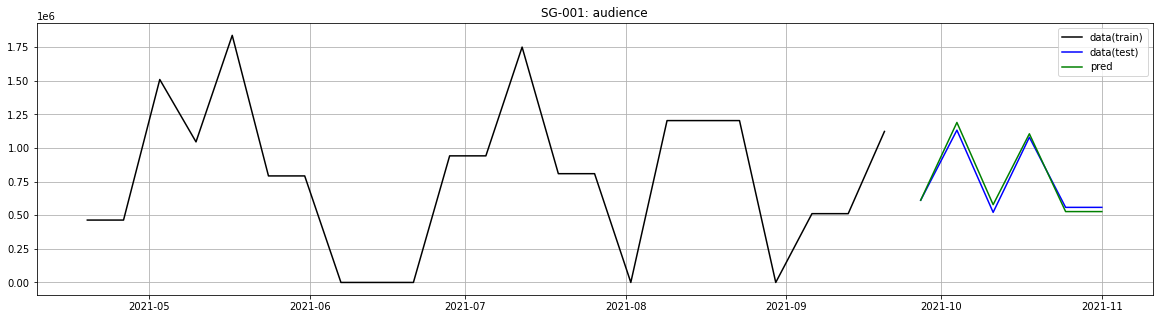

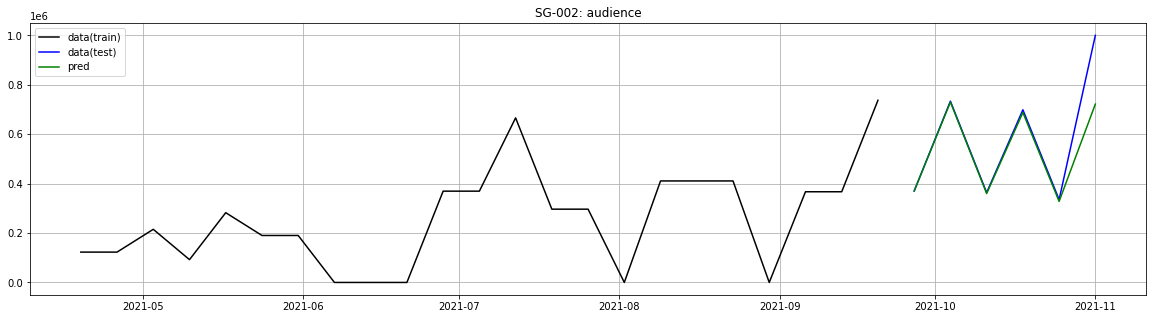

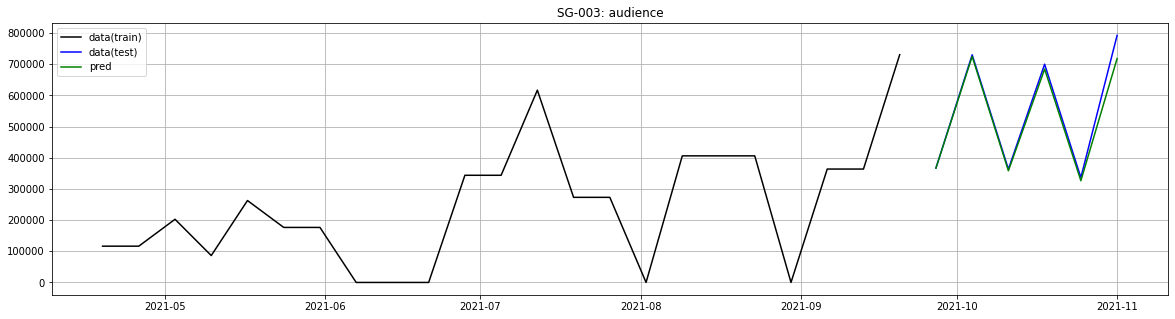

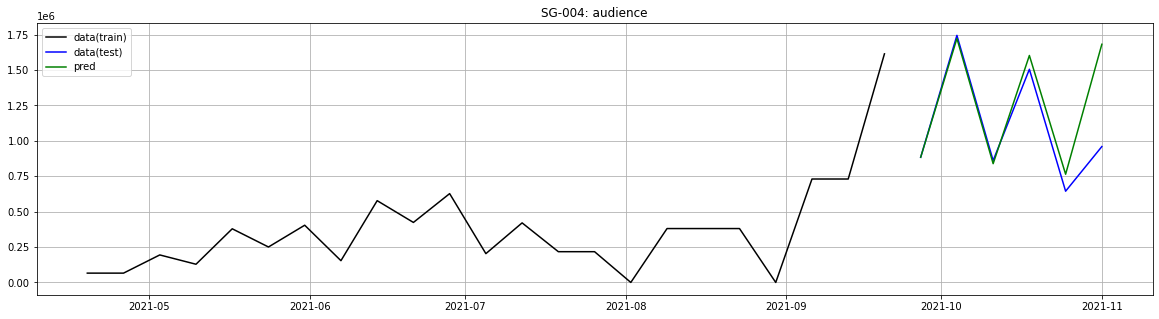

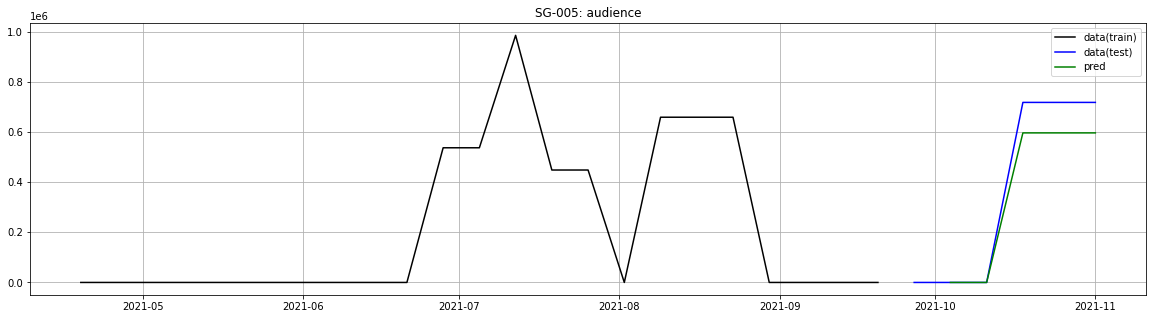

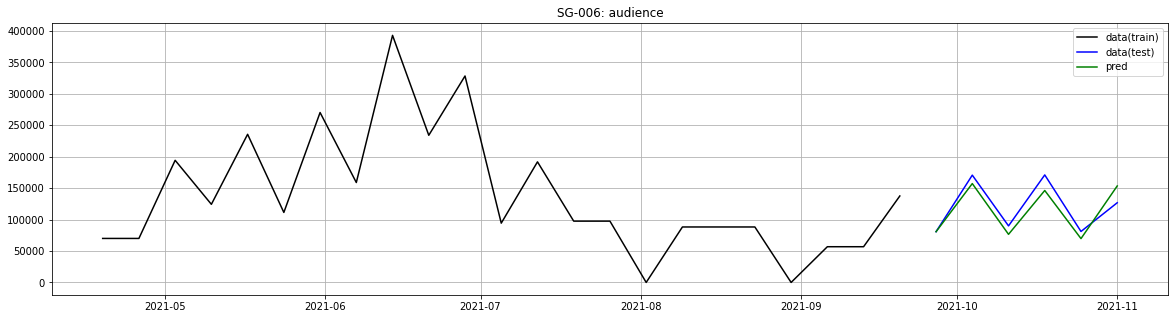

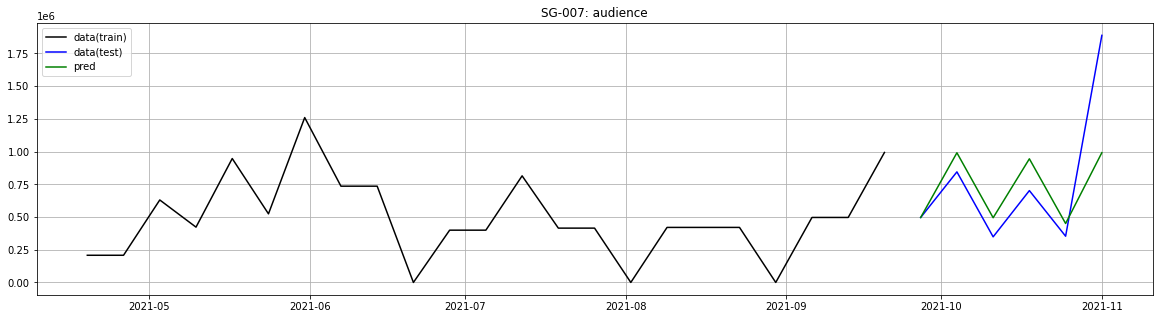

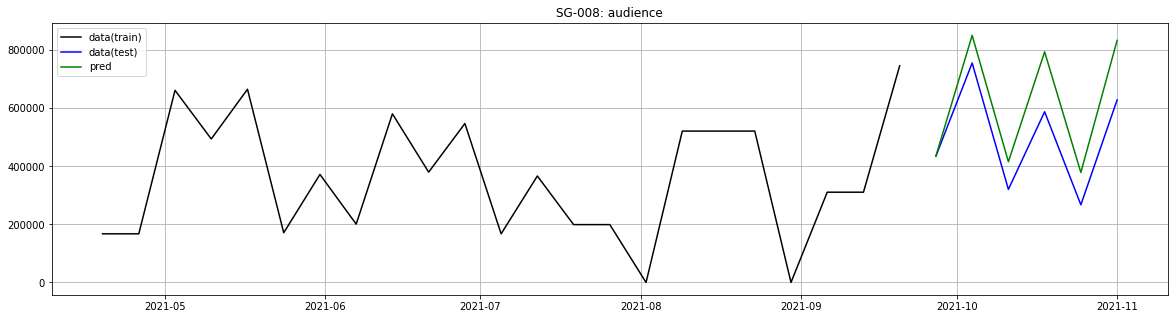

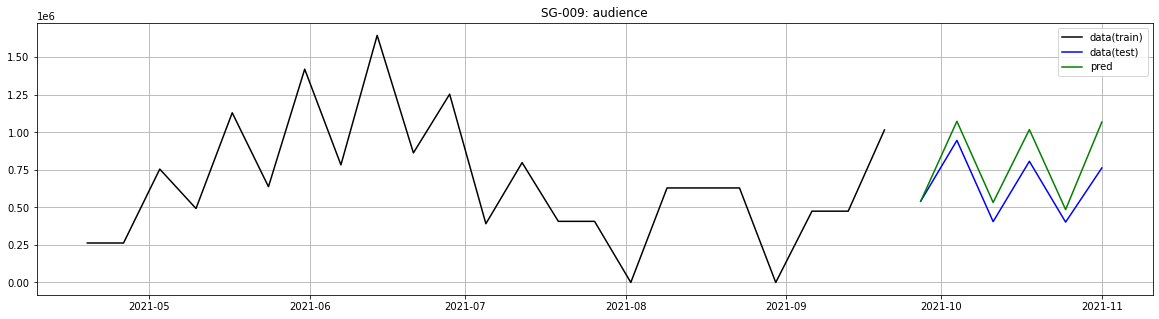

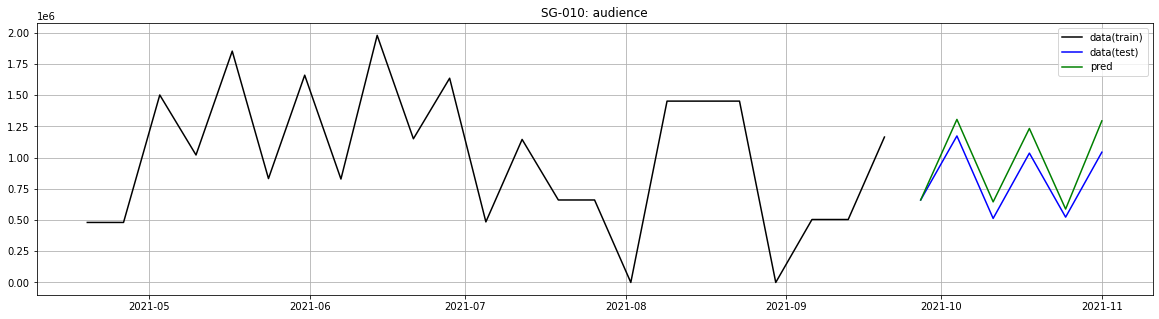

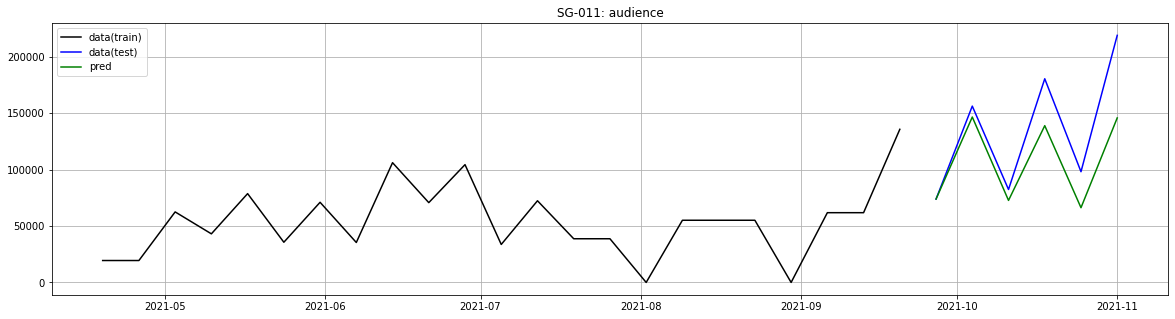

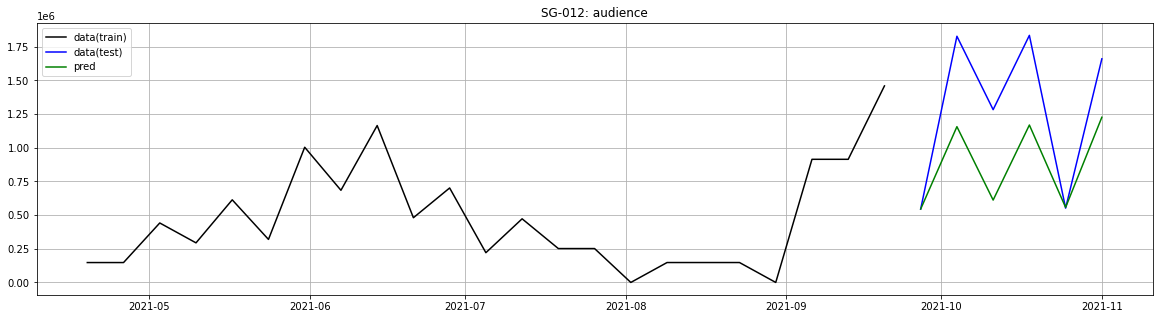

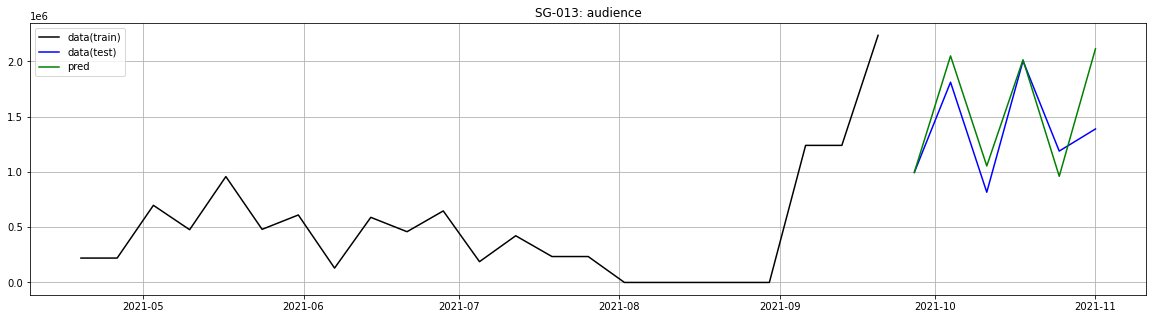

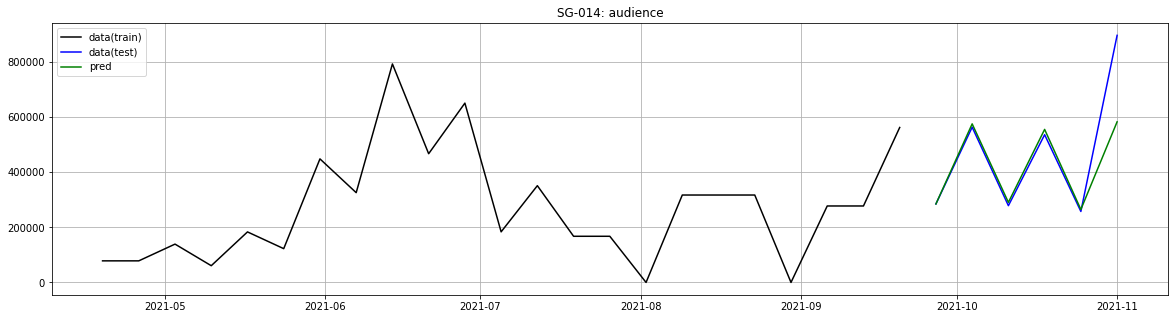

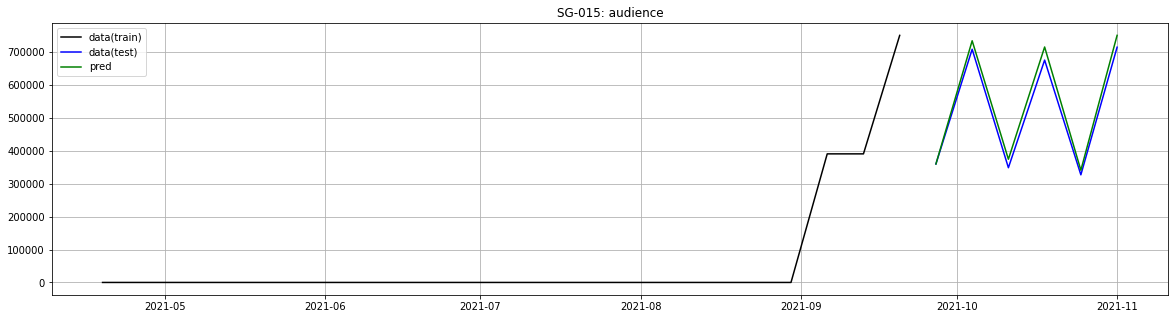

In [31]:
# for metric in ['rpc', 'rdm', 'cost', 'inc_sales']:
for metric in ['audience']:
    for offer_type in OFFER_TYPES:

        campaign_weekly_history = weekly_history[weekly_history.offer_type == offer_type]
        campaign_weekly_forecast = weekly_forecast[weekly_forecast.offer_type == offer_type]
        campaign_weekly_holdout = weekly_holdout[weekly_holdout.offer_type == offer_type]
        
        plt.figure(figsize=(20,5))
        plt.title(f'{offer_type}: {metric}')
        plt.plot(campaign_weekly_history.ds, campaign_weekly_history[metric], color='k', label='data(train)')
        plt.plot(campaign_weekly_holdout.ds, campaign_weekly_holdout[metric], color='b', label='data(test)')
        plt.plot(campaign_weekly_forecast.ds, campaign_weekly_forecast[metric], color='g', label='pred')
        plt.legend()
        plt.grid()
        plt.show()

### Overall prediction

In [22]:
def get_weekly_all(df):
    df = df.groupby(['ds']).aggregate({'audience': 'sum', 'inc_sales': 'sum', 'cost': 'sum', 'redeemers':'sum'}).reset_index()
    df['rpc'] = df['inc_sales'] / df['audience']
    df['rdm'] = df['redeemers'] / df['audience']
    
    return df


weekly_forecast_all = get_weekly_all(weekly_forecast)
weekly_history_all = get_weekly_all(weekly_history)
weekly_holdout_all = get_weekly_all(weekly_holdout)

sMAPE = 21.646717063235354


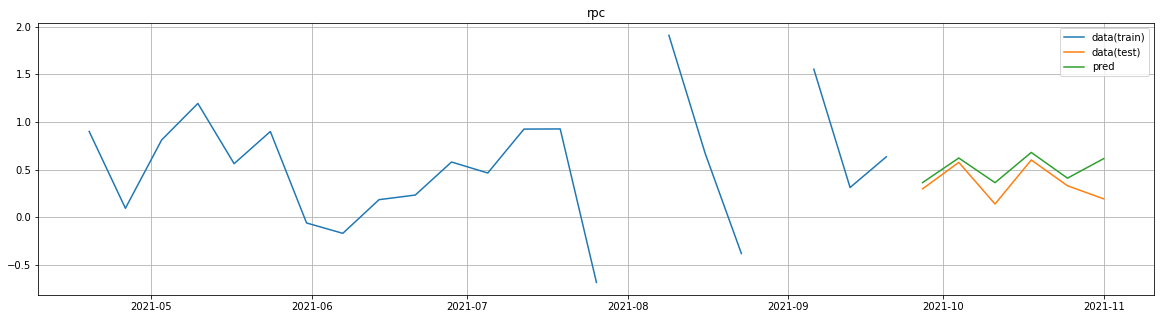

sMAPE = 21.26646420462903


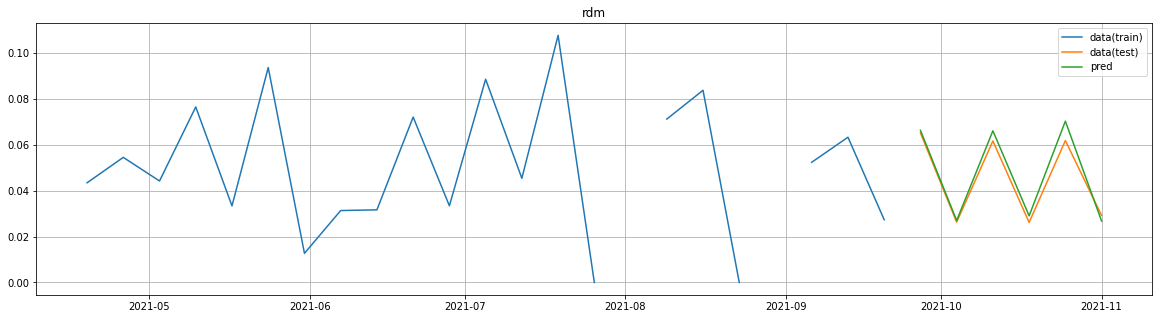

sMAPE = 3.597717809650347


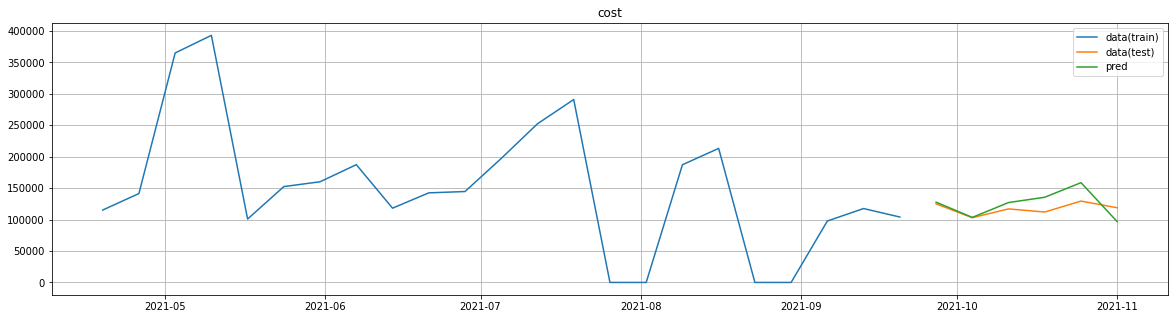

sMAPE = 5.887688583849177


In [23]:
def eval_smape(y, yhat):
    return np.mean(np.abs(yhat - y) / (np.abs(yhat) + np.abs(y))) * 100

metrics = ['inc_sales', 'rpc', 'rdm', 'cost']

for metric in metrics:
    
    plt.figure(figsize=(20,5))
    plt.title(f'{metric}')
    plt.plot(weekly_history_all.ds, weekly_history_all[metric], label='data(train)')
    plt.plot(weekly_holdout_all.ds, weekly_holdout_all[metric], label='data(test)')
    plt.plot(weekly_forecast_all.ds, weekly_forecast_all[metric], label='pred')
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f'sMAPE = {eval_smape(weekly_holdout_all[metric], weekly_forecast_all[metric])}')

### Monthly

In [24]:
sql = '''
    SELECT * 
    FROM (
        SELECT DISTINCT 
            fp_start_date AS dt, 
            fw_start_date AS ds
        FROM `wx-bq-poc.loyalty.dim_date`
        WHERE fp_start_date >= '2020-08-31'
            AND DATE(fp_end_date) < current_date('Australia/ACT')
    )
'''

monthly = bq.query(sql).result().to_dataframe()

In [25]:
def get_monthly(df):
    month_agg_data = monthly.merge(df, left_on='ds', right_on='ds').sort_values(by='dt')
    month_agg_data = month_agg_data.groupby('dt').aggregate({
        'audience': 'sum',
        'inc_sales': 'sum',
        'cost': 'sum',
        'redeemers': 'sum',
    }).reset_index()

    month_agg_data['rpc'] = month_agg_data['inc_sales'] / month_agg_data['audience']
    month_agg_data['rdm'] = month_agg_data['redeemers'] / month_agg_data['audience']
    
    return month_agg_data

monthly_forecast = get_monthly(weekly_forecast_all)

In [26]:
weekly_data = get_weekly_all(data)
monthly_data = get_monthly(data)

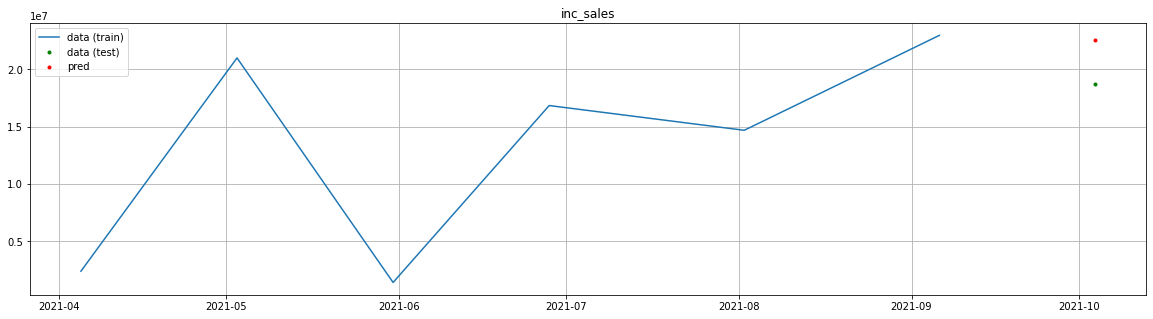

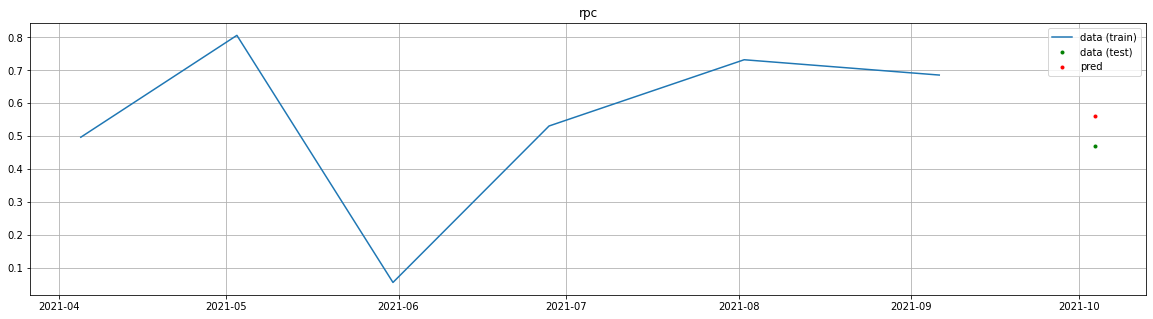

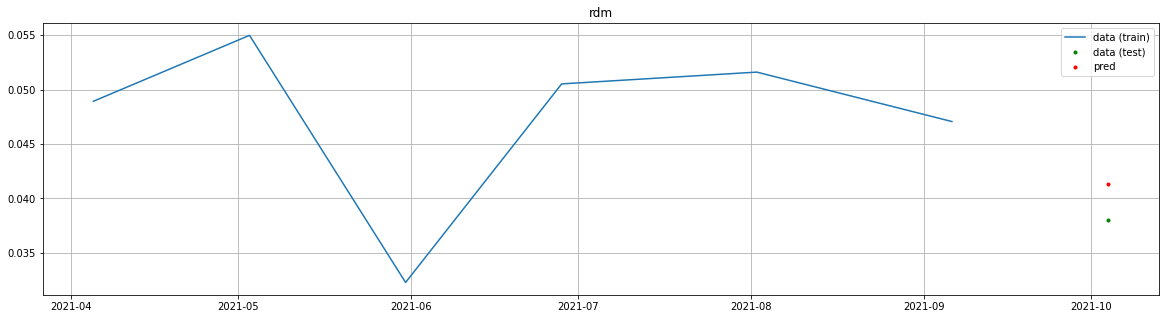

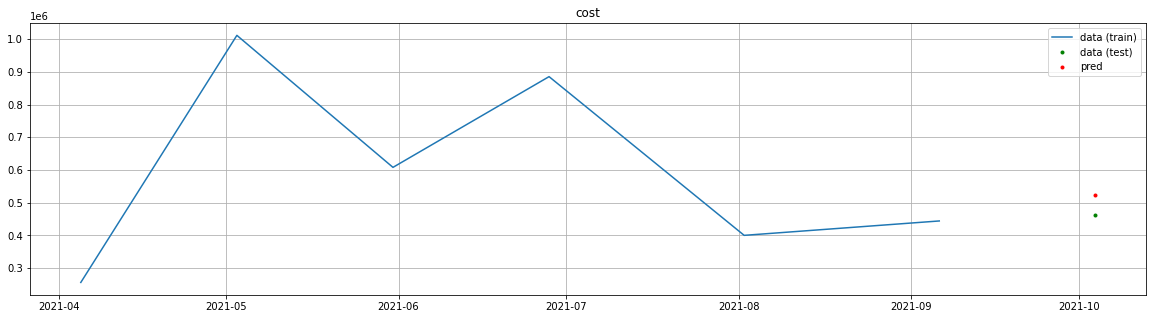

In [27]:
metrics = ['inc_sales', 'rpc', 'rdm', 'cost']

for metric in metrics: 
    
    ds = monthly_data['dt']
    y = monthly_data[metric]
    yhat = monthly_forecast[metric]

    plt.figure(figsize=(20,5))
    plt.title(metric)
    plt.plot(ds[:-1], y[:-1], label='data (train)')
    plt.plot(ds[-1:], y[-1:], 'g.', label='data (test)')
    plt.plot(ds[-1:], yhat[-1:], 'r.', label=f'pred')
    plt.legend()
    plt.grid()
    plt.show()

### Marketing comparison

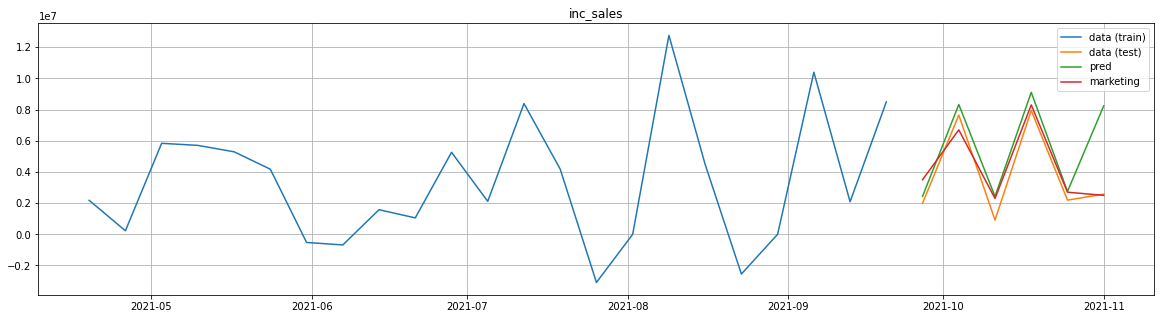

sMAPE (marketing) : 15.186249446704672
sMAPE (ours)      : 21.646717063235357


In [28]:
metric = 'inc_sales'
marketing_forecast = [3500000.00, 6700000.00, 2300000.00, 8300000.00, 2700000.00, 2500000.00]

ds = weekly_data['ds']
y = weekly_data[metric]
yhat = weekly_forecast_all[metric]

plt.figure(figsize=(20,5))
plt.title(metric)
plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
plt.plot(ds[-WINDOW:], yhat, label=f'pred')
plt.plot(ds[-WINDOW:], marketing_forecast, label=f'marketing')
plt.legend()
plt.grid()
plt.show()

print(f'sMAPE (marketing) : {eval_smape(np.array(marketing_forecast), np.array(y[-WINDOW:]))}')
print(f'sMAPE (ours)      : {eval_smape(np.array(yhat), np.array(y[-WINDOW:]))}')

In [29]:
metric = 'cost'
marketing_forecast = [250000, 200000, 250000, 100000, 140000, 200000]

ds = weekly_data['ds']
y = weekly_data[metric]
yhat = weekly_forecast_all[metric]

plt.figure(figsize=(20,5))
plt.title(metric)
plt.plot(ds[:-WINDOW], y[:-WINDOW], label='data (train)')
plt.plot(ds[-WINDOW:], y[-WINDOW:], label='data (test)')
plt.plot(ds[-WINDOW:], yhat, label=f'pred')
plt.plot(ds[-WINDOW:], marketing_forecast, label=f'marketing')
plt.legend()
plt.grid()
plt.show()

print(f'sMAPE (marketing) : {eval_smape(np.array(marketing_forecast), np.array(y[-WINDOW:]))}')
print(f'sMAPE (ours)      : {eval_smape(np.array(yhat), np.array(y[-WINDOW:]))}')

sMAPE (marketing) : 22.778736994826822
sMAPE (ours)      : 5.887688583849177
